In [6]:
import os
import math
import pytest
import random
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit_aer import Aer
from qiskit.circuit.library import QFT
from qiskit.circuit.library import MCXGate
from qiskit.circuit.library import Diagonal
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import GroverOperator

from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

In [7]:
import qiskit
print(qiskit.version.get_version_info())

1.2.4


In [8]:
def preprocess(L):
    """
    Compute qubit count n and padded list L_pad so that
    N = 2**n >= len(L), and avoid the M/N=1/2 dead zone.
    """
    n = math.ceil(math.log2(len(L)))
    N = 2**n
    if len(L) / N == 0.5:
        n += 1
        N = 2**n
    L_pad = L + [float("inf")] * (N - len(L))
    return n, N, L_pad


def build_diffuser(n):
    """Standard Grover diffusion operator on n qubits."""
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    return qc.to_gate(label="Diffuser")


def optimal_grover_iterations(N, M):
    """Return k = ⌊(π/4)·√(N/M)⌋."""
    return math.floor((math.pi / 4) * math.sqrt(N / M))


def grover_search_less_than(L_pad, n, threshold, shots=2048, validation=[]):
    """
    Run one Grover search to find ANY index j with L_pad[j] < threshold.
    Returns the most-frequent index, or None if no j< threshold exists.
    """
    N = len(L_pad)
    # Mark all j where L_pad[j] < threshold and j in validation
    if validation == []:
        marked = [i for i, v in enumerate(L_pad) if (v is not None and v < threshold)]
    else:
        marked = [
            i
            for i, v in enumerate(L_pad)
            if (v is not None and v < threshold and i in validation)
        ]
    # print(f"find_min_mark: {marked}")
    M = len(marked)
    if M == 0:
        return None  # no smaller element

    # Build diagonal oracle: -1 on marked, +1 otherwise
    diag = [(-1 if i in marked else +1) for i in range(N)]
    oracle = UnitaryGate(np.diag(diag), label=f"Or<{threshold}>")

    diffuser = build_diffuser(n)
    k = optimal_grover_iterations(N, M)

    # Build the Grover circuit with k iterations
    qc = QuantumCircuit(n, n)
    qc.h(range(n))
    for _ in range(k):
        qc.append(oracle, range(n))
        qc.append(diffuser, range(n))
    qc.measure(range(n), range(n))

    # Execute on simulator
    backend = Aer.get_backend("qasm_simulator")
    qc_t = transpile(qc, backend=backend, optimization_level=3)
    counts = backend.run(qc_t, shots=shots).result().get_counts()

    # Pick the index with highest count
    winner = max(counts, key=counts.get)
    return int(winner, 2)


def quantum_minimum(L, validation=[]):
    """
    Dürr & Høyer minimum-finding:
    Repeatedly search for any element < current best, updating until done.
    Returns (index_of_minimum, value).
    """
    # Special case: if every entry is the same, just return 0 immediately
    if len(set(L)) == 1:
        return 0, L[0]

    # 1) Preprocess
    n, N, L_pad = preprocess(L)

    # 2) Initialize threshold to L[0]
    idx_star = None
    x_star = max(v for v in L if v is not None) + 1

    # 3) Iterate until no smaller element is found
    while True:
        result = grover_search_less_than(L_pad, n, x_star, validation=validation)
        if result is None:
            # no element < x_star exists → x_star is the minimum
            return idx_star, x_star
        # else update best guess
        idx_star = result
        x_star = L_pad[result]

In [9]:
def get_vector(qc):
    backend = Aer.get_backend("statevector_simulator")
    qc_compile = transpile(qc, backend=backend, optimization_level=3)
    statevector = backend.run(qc_compile).result().get_statevector()
    return statevector

In [10]:
def optimized_phase_oracle(n: int, marked_indices: list[int]):
    """
    Returns a Gate that applies |i> -> -|i> if i is in marked_indices,
    using an OR-tree over per-index comparisons.
    """
    M = len(marked_indices)
    # 1) Define subcircuit that computes the OR-tree into a single ancilla
    idx = QuantumRegister(n, name="idx")
    flags = AncillaRegister(M, name="flag")  # one per marked index
    oranc = AncillaRegister(M - 1, name="or")  # workspace for OR-tree

    compute = QuantumCircuit(idx, flags, oranc, name="OracleCompute")

    # (a) Parallel comparators → flags[j] = 1 iff idx == marked_indices[j]
    for j, target in enumerate(marked_indices):
        bits = [(target >> k) & 1 for k in range(n)]
        for k, b in enumerate(bits):
            if b == 0:
                compute.x(idx[k])
        compute.mcx(idx[:], flags[j])
        for k, b in enumerate(bits):
            if b == 0:
                compute.x(idx[k])

    # (b) OR-tree: pairwise OR flags → oranc[-1] will hold the overall OR
    current = list(flags)
    work = list(oranc)
    wi = 0
    while len(current) > 1:
        next_lvl = []
        for i in range(0, len(current), 2):
            if i + 1 < len(current):
                a, b = current[i], current[i + 1]
                t = work[wi]
                wi += 1
                # t = a OR b  via De Morgan:
                compute.x(a)
                compute.x(b)
                compute.mcx([a, b], t)
                compute.x(a)
                compute.x(b)
                compute.x(t)
                next_lvl.append(t)
            else:
                next_lvl.append(current[i])
        current = next_lvl

    root = current[0]  # this flag now = 1 iff idx∈marked_indices

    # Turn this compute circuit into a gate we can invert
    compute_gate = compute.to_gate()
    compute_inv = compute_gate.inverse()

    # 2) Build full Oracle: compute → phase → uncompute
    full = QuantumCircuit(idx, flags, oranc, name="OracleOpt")
    full.append(compute_gate, full.qubits)  # compute root flag
    full.z(root)  # phase-kick on root
    full.append(compute_inv, full.qubits)  # uncompute everything

    return full.to_gate()


def inc_modM_gate_ripple(n_qubits: int, M: int):
    """Optimized |i> -> |(i+1) mod M> on n_qubits, uses 1 ancilla."""
    qc = QuantumCircuit(n_qubits + 1, name=f"inc_mod{M}")
    anc = n_qubits  # workspace qubit

    # --- 1) Simple ripple increment mod 2^n ---
    qc.x(0)
    for j in range(1, n_qubits):
        qc.mcx(list(range(j)), j)

    # --- 2) Build little-endian bit masks for M and (2^n − M) ---
    M_le = [(M >> i) & 1 for i in range(n_qubits)]
    M_comp_le = [(((1 << n_qubits) - M) >> i) & 1 for i in range(n_qubits)]

    # --- 3) Comparator: ancilla=1 iff (i+1)==M ---
    #    Flip all data qubits where M_le[k]==0 so that MCX tests equality
    for k, bit in enumerate(M_le):
        if bit == 0:
            qc.x(k)
    qc.mcx(list(range(n_qubits)), anc)
    #    Unflip
    for k, bit in enumerate(M_le):
        if bit == 0:
            qc.x(k)

    # --- 4) Conditional subtract-M: add two's-complement of M ---
    for j, bit in enumerate(M_comp_le):
        if bit:
            if j == 0:
                qc.cx(anc, 0)
            else:
                qc.mcx([anc] + list(range(j)), j)

    # --- 5) Uncompute comparator ancilla ---
    for k, bit in enumerate(M_le):
        if bit == 0:
            qc.x(k)
    qc.mcx(list(range(n_qubits)), anc)
    for k, bit in enumerate(M_le):
        if bit == 0:
            qc.x(k)

    return qc.to_gate()

In [11]:
def pre_process(L, target, validation):
    M = len(L)
    n = int(np.ceil(np.log2(len(L))))
    total_quibit = 2**n
    if validation != []:
        count_target = sum(
            1 for indx, x in enumerate(L) if x == target and indx in validation
        )
    else:
        count_target = sum(1 for x in L if x == target)
    if count_target / total_quibit >= 0.5:
        n += 1
    N = 2**n
    L_pad = L + [None] * (N - len(L))
    return n, N, M, L_pad, count_target


def phase_oracle(diagonal):
    """
    Build a single Diagonal gate which applies phase(diagonal[i]) to |i>.
    `diagonal` must be a list or np.array of length 2**n_qubits containing ±1.
    """
    # Create the gate
    oracle_gate = Diagonal(diagonal)
    oracle_gate.name = "Oracle"
    return oracle_gate


def diffuser(n_qubits):
    qc = QuantumCircuit(n_qubits, name="Diffuser")
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    return qc.to_gate()


def inc_modM_gate(n_qubits: int, M: int) -> UnitaryGate:
    """
    Returns an n-qubit gate that maps |i> -> |(i+1) mod M> for i<M,
    and |i> -> |i> for i>=M.
    """
    N = 2**n_qubits
    # start with identity
    P = np.eye(N, dtype=complex)
    # overwrite the rows for 0..M-1
    for i in range(M):
        P[i, i] = 0  # clear the old diagonal entry
        P[(i + 1) % M, i] = 1  # redirect to (i+1)%M
    # rows M..N-1 remain the identity
    return UnitaryGate(P, label=f"inc_mod{M}")


def optimal_grover_iterations(N: int, M: int) -> int:
    """
    Return the optimal number of Grover iterations for
    N total states with M marked states:

        k = floor((pi/4) * sqrt(N/M))

    Args:
        N: total number of basis states (e.g. 2**n)
        M: number of marked states

    Returns:
        k: integer number of iterations
    """
    if M <= 0 or M > N:
        raise ValueError("Require 1 ≤ M ≤ N")
    return math.floor((math.pi / 4) * math.sqrt(N / M))


def pick_top(counts: dict[str, int]) -> int:
    """
    Given a counts dict from Qiskit, return the integer index
    of the most-measured bitstring.
    """
    bitstr = max(counts, key=counts.get)
    return int(bitstr, 2)


def validation_index(qc, round_idx, print_stat_file=None):
    backend_sim = Aer.get_backend("qasm_simulator")
    qc_compile = transpile(qc, backend=backend_sim, optimization_level=3)
    job_sim = backend_sim.run(qc_compile, shots=2048)
    counts = job_sim.result().get_counts()
    top = pick_top(counts)

    total_counts = sum(counts.values())
    probs = {int(key, 2): value / total_counts for key, value in counts.items()}
    candidates = [
        int(key, 2) for key, value in counts.items() if value / total_counts > 0.05
    ]
    fig = plot_histogram(probs, title=f"Stat at {round_idx}")
    if print_stat_file:
        file_folder = str(print_stat_file)
        file_name = str("find_" + str(top))
        if not os.path.exists(file_folder):
            os.makedirs(file_folder)
        fig.savefig(os.path.join(file_folder, file_name))
    else:
        fig.savefig(f"test")
    return candidates, top, probs[top]


def build_grover_increment_circuit(n, oracle, diffuser, inc_modM, k):
    q = range(n)
    qc = QuantumCircuit(n, n)
    qc.h(q)
    for _ in range(k):
        qc.append(oracle, q)
        qc.append(diffuser, q)
    qc.append(inc_modM, q)
    qc_compile = get_vector(qc)
    qc.measure(q, q)
    return qc


def build_grover_increment_circuit_ver_2(n, oracle, diffuser, inc_modM, k):
    qc = QuantumCircuit(n + 1, n)
    idx = list(range(n))  # index‐register qubits: 0..n-1
    anc = n  # ancilla qubit: index n

    # Initialize into uniform superposition on the index register
    qc.h(idx)

    # Grover iterations
    for _ in range(k):
        qc.append(oracle, idx)  # phase oracle on the n data qubits
        qc.append(diffuser, idx)  # diffuser on the same n qubits
    qc.append(inc_modM, idx + [anc])  # ripple inc gate needs n+1 qubits

    # (Optional) compile / vectorize if you use get_vector
    # qc_compile = get_vector(qc)

    # Measure only the index register into your n classical bits
    qc.measure(idx, list(range(n)))

    return qc


def build_grover_increment_circuit_ver_3(n, marked, diffuser, inc_modM, k):
    M = len(marked)
    # 1) index register
    idx = QuantumRegister(n, name="idx")
    # 2) oracle‐flags
    flags = AncillaRegister(M, name="flag")
    # 3) OR‐tree work
    oranc = AncillaRegister(M - 1, name="or")
    # 4) ripple‐increment ancilla
    inc_anc = AncillaRegister(1, name="inc_anc")
    # 5) classical bits for measurement
    cr = ClassicalRegister(n, name="c")
    qc = QuantumCircuit(idx, flags, oranc, inc_anc, cr, name="LMSR_Grover")

    # superposition
    qc.h(idx)

    # build the oracle once
    oracle = optimized_phase_oracle(n, marked)

    # Grover loops
    for _ in range(k):
        qc.append(oracle, idx[:] + flags[:] + oranc[:])  # must give all oracle qubits
        qc.append(diffuser, idx[:])
    qc.append(inc_modM, idx[:] + [inc_anc[0]])

    # measure only the index qubits
    qc.measure(idx, cr)

    return qc


def LMSR_Q(L: list, print_qc=False, print_stat_file=None, ver=1):

    if len(set(L)) == 1:
        return 0

    validation = []
    round_idx = 0
    thread_top = 0.0
    while True:
        indx, target = quantum_minimum(L, validation=validation)
        n, N, M, L_pad, count_target = pre_process(L, target, validation)
        diag = [
            (-1 if L_pad[i] == target and (validation == [] or i in validation) else 1)
            for i in range(N)
        ]
        oracle_gate = phase_oracle(diag)
        diffuse_gate = diffuser(n)
        inc_modM = inc_modM_gate(n, M)
        k = optimal_grover_iterations(N, count_target)
        qc = build_grover_increment_circuit(n, oracle_gate, diffuse_gate, inc_modM, k)
        validation, top, thread_top = validation_index(qc, round_idx, print_stat_file)
        # print(f"Val: {validation}")
        # print(top, thread_top, round_idx)
        # print(f"-----------------")
        if len(validation) == 1:
            break
        if thread_top > 0.8:
            break
        if round_idx == 10:
            break
        round_idx += 1
    start_idx = (top - round_idx - 1) % M
    if print_qc:
        return start_idx, qc
    else:
        return start_idx

In [12]:
def LMSR_Q1(L: list, print_qc=False):
    n0 = len(L)
    # all-equal edge case
    if len(set(L)) == 1:
        return (0, None) if print_qc else 0

    # we keep track of which rotation-start indices are still in the running
    validation = list(range(n0))
    round_idx = 0
    last_qc = None

    while True:
        # 1) Build the “k-th character” list for each still-candidate rotation:
        #    symbol_list[i] = L[ (i + round_idx) % n0 ]
        symbol_list = [L[(i + round_idx) % n0] for i in range(n0)]
        # print(symbol_list)

        # 2) Run your quantum_minimum on *that* list, restricted to `validation`
        #    quantum_minimum returns (rel_idx, target_symbol)
        rel_idx, target = quantum_minimum(symbol_list, validation=validation)
        # (if you need the final circuit, have your quantum_minimum also return the qc)
        print(validation)

        # 3) Update validation = those i whose k-th symbol == target
        validation = [i for i in validation if symbol_list[i] == target]

        # 4) Termination: if exactly one candidate remains (or we've exhausted all characters)
        if len(validation) == 1 or round_idx + 1 >= n0:
            start_idx = validation[0]
            if print_qc:
                return start_idx, last_qc
            return start_idx

        round_idx += 1

In [13]:
# Basic fixed test cases
test_cases = [
    ([1, 3, 1, 4, 1, 1], 4),
    ([1, 1, 2, 1, 1, 1, 4], 3),
    ([1, 3, 1, 4, 1, 6], 0),
    ([2, 6, 2, 2, 1, 6, 4, 2, 5, 1, 3], 9),
    ([1, 1, 1, 1, 1, 1, 1, 1], 0),
]


@pytest.mark.parametrize("L, expected", test_cases)
def test_lmsr_basic_cases():
    """
    For each list L, LMSR(L) should return the index of the lexicographically
    minimal rotation, as given in the examples.
    """
    for test in test_cases:
        result = LMSR_Q(test[0])
        assert isinstance(result, int), "LMSR should return an integer index"
        assert result == test[1]
        print(f"[Pass] Test Base: {test[0]} -> {test[1]}")


def rotate_list(L, k):
    """Return the list L rotated by k positions."""
    n = len(L)
    return L[k:] + L[:k]


def is_lex_min(L, idx):
    """Check that rotation at idx gives the lexicographically minimal list."""
    candidate = tuple(rotate_list(L, idx))
    for k in range(len(L)):
        if tuple(rotate_list(L, k)) < candidate:
            return False
    return True


def test_lmsr_property_random():
    """
    Property-based test: for random lists of numbers 1-6,
    check that the LMSR index yields the lexicographically minimal rotation.
    """
    for test in range(3):
        # Generate a random list length between 5 and 15
        length = random.randint(20, 60)
        L = [random.randint(1, 6) for _ in range(length)]
        idx = LMSR_Q(L)
        # Must be valid index
        assert 0 <= idx < len(L)
        # Check the lexicographic minimality property
        try:
            assert is_lex_min(L, idx)
            print(f"[Pass] Test {test}: {L} -> {idx}/{len(L) - 1}")
        except AssertionError:
            print(
                f"Error: The rotation at index {idx} is not lexicographically minimal"
            )
            print(f"List: {L}")
            print(f"Rotation at {idx}: {rotate_list(L, idx)}")
            # raise


# test_lmsr_basic_cases()
test_lmsr_property_random()

[Pass] Test 0: [5, 1, 2, 5, 3, 2, 4, 6, 3, 2, 6, 2, 2, 2, 3, 4, 3, 1, 4, 4] -> 1/19
[Pass] Test 1: [4, 6, 4, 2, 2, 3, 4, 1, 4, 6, 4, 1, 2, 5, 4, 1, 4, 5, 5, 3, 1, 4, 6, 6, 3, 6, 4, 3, 5, 1, 5, 5, 2, 6, 1, 5, 4, 2, 1, 1, 6, 2, 4, 5] -> 38/43
[Pass] Test 2: [6, 5, 2, 3, 1, 3, 6, 6, 1, 6, 2, 1, 3, 2, 1, 3, 3, 5, 2, 4, 1, 2, 1, 4, 1, 4, 4, 6, 6, 1, 2, 2, 5, 6, 6, 2, 2, 1, 3, 5, 5, 1, 6, 3, 1, 1, 4, 5, 6, 6, 5, 5, 3, 6, 5, 4, 4, 2] -> 44/57


Start at 0


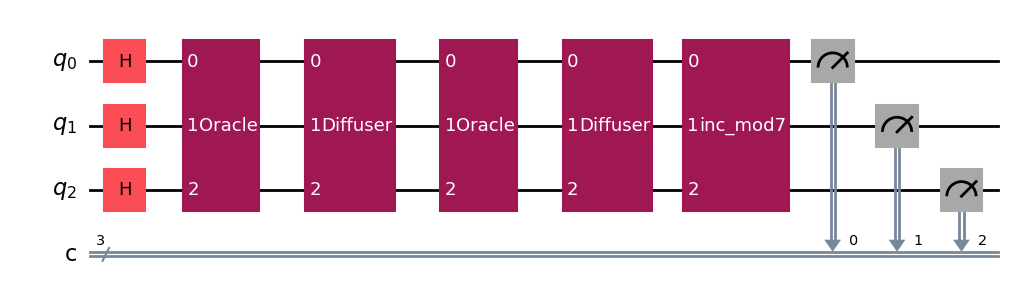

In [14]:
L = [1, 1, 1, 1, 1, 1, 2]
res, qc = LMSR_Q(L, print_qc=True, print_stat_file="result")
print(f'Start at {res}')
qc.draw(output="mpl", scale=1)

Start at 4


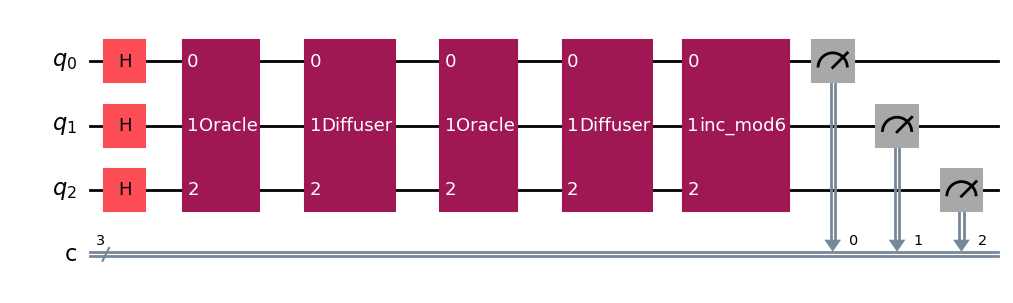

In [17]:
L = [1, 3, 1, 4, 1, 1]
res, qc = LMSR_Q(L, print_qc=True, print_stat_file="list")
print(f'Start at {res}')
qc.draw(output="mpl", scale=1)

TypeError: FigureCanvasAgg.print_png() got an unexpected keyword argument 'figsize'

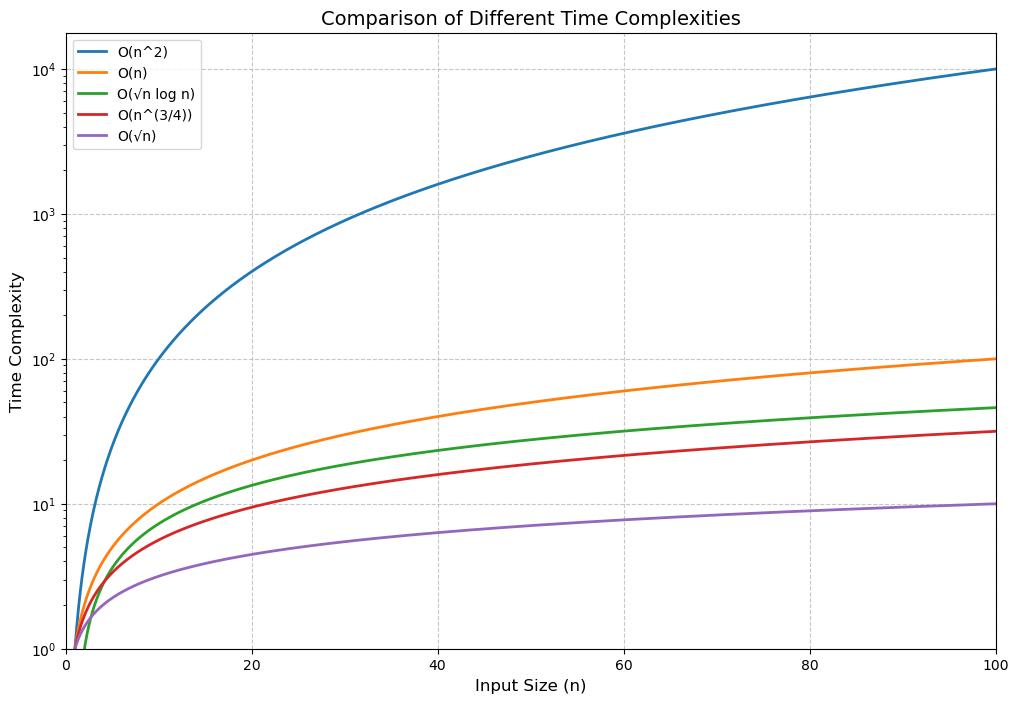

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values (n)
n = np.linspace(1, 100, 1000)

# Calculate different complexity functions
sqrt_n = np.sqrt(n)
sqrt_n_log_n = np.sqrt(n) * np.log(n)
linear_n = n
quadratic_n = n**2
n_34 = n**(3/4)

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(n, quadratic_n, label='O(n^2)', linewidth=2)
plt.plot(n, linear_n, label='O(n)', linewidth=2)
plt.plot(n, sqrt_n_log_n, label='O(√n log n)', linewidth=2)
plt.plot(n, n_34, label='O(n^(3/4))', linewidth=2)
plt.plot(n, sqrt_n, label='O(√n)', linewidth=2)

# Customize the plot
plt.title('Comparison of Different Time Complexities', fontsize=14)
plt.xlabel('Input Size (n)', fontsize=12)
plt.ylabel('Time Complexity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)


# Set y-axis to logarithmic scale for better visualization
plt.yscale('log')
plt.xlim(0, 100)  # Set x-axis to start at 0
plt.ylim(1, None)  # Set y-axis to start at 1 (since log scale)
plt.savefig('scaling_plot.png', dpi=300, bbox_inches='tight')
